## Notebook 03 (Project 04)

---

### **🧠 1. Introduction & Motivation**

In the previous notebook, we saw that **smart weight initialization** (like Xavier or He) can greatly improve the training of deep MLPs by helping gradients flow more reliably.

But even with good initialization, **deep networks are still hard to train**.

> The reality is: initialization is necessary, but not sufficient.

As we go deeper, we face new challenges that affect not just **whether learning happens**, but also **how fast and stable** that learning is — and how well the model generalizes to unseen data.

> **🚧 Why Deep Networks Still Struggle**

1. **Unstable Gradients**
- Gradients can still **vanish** (become tiny) or **explode** (become huge), especially across many layers.
- This leads to:
  - **Stalled or slow learning**
  - **Divergence** (loss becomes NaN or shoots up)
  - Layers updating at **different speeds**, leading to instability

2. **Fragile Training Dynamics**
- Deeper networks often need **careful tuning** and **more epochs** to converge.
- A single mistake — like a bad learning rate — can **ruin training**.

3. **Internal Covariate Shift**
- As parameters update during training, the **distribution of activations** changes layer-by-layer.
- This forces deeper layers to **constantly adapt** to a moving target — slowing learning and increasing variance.

>**🛠️ How Can We Help Deep Networks Learn?**

In this notebook, we’ll explore three **core techniques** that have become standard in modern deep learning:

| 💡 Idea                  | 🚀 How It Helps |
|--------------------------|-----------------|
| **Batch Normalization**   | Normalizes layer inputs to reduce internal covariate shift, stabilize and speed up training. |
| **Adaptive Optimizers**   | Optimizers like Adam and RMSProp adjust learning rates dynamically — helping the model learn faster. |
| **Regularization Methods**| Dropout and L2 penalty reduce overfitting and improve generalization performance. |

Each of these targets a **specific pain point** we often face when training deep models.

>🔍 What We'll Do in This Notebook

We’ll build upon the deep MLP we trained in NB02, and **incrementally improve it** using the techniques above.

Here’s our roadmap:

1. 📊 **Train a deep MLP baseline** using default optimizer (SGD) — observe slow and unstable learning.
2. 🧼 Add **Batch Normalization** — see how it stabilizes activations and accelerates convergence.
3. ⚙️ Try **adaptive optimizers** — compare SGD, Adam, and RMSProp to study learning speed and consistency.
4. 🛡️ Introduce **Dropout and L2 regularization** — reduce overfitting and improve generalization to the test set.
5. 📈 Evaluate all models on:
   - **Training & validation loss and accuracy**
   - **F1 scores** (for more informative multi-class evaluation)
   - **Stability and gradient flow** across training

📌 By the end of this notebook, we’ll have a **robust understanding of how to train deep networks** reliably.  
These techniques are essential as we move to **CNNs and other deep architectures** in upcoming notebooks.

---

### **2. Load & Preprocess CIFAR-10**

To ensure this notebook is **self-contained** and **reproducible**, we’ll:

- 📥 Reload the CIFAR-10 dataset
- 🎨 Normalize pixel values to help neural network training
- 📏 Flatten 3×32×32 RGB images into 1D vectors (3072 features)
- ✂️ Split the data into training, validation, and test sets

> **Recap: Why Normalize the Data?**

Neural networks **learn better** when input features are:
- **Centered** around 0 (mean ≈ 0)
- **Scaled** to have consistent spread (variance ≈ 1)

For image data:
- Pixel values are first scaled to `[0, 1]` using `ToTensor()`.
- Then we **standardize across color channels** (RGB) to get values in `[-1, 1]`.

This helps:
- Avoid exploding activations early in training.
- Make gradient descent behave more predictably.

> **Recap: Why Flatten the Images?**

Our MLPs expect **1D feature vectors** as input.

So we reshape the original images from shape `[3, 32, 32]` → `[3072]`  
This is done *only* for MLPs.  
When we work with CNNs later, we’ll preserve the original 3D shape.

**Load, Normalize, Flatten, and Split**

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)

# 1. Define transforms: ToTensor + Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts from [0, 255] → [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standardize to [-1, 1]
])

# 2. Load CIFAR-10 dataset
trainval_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 3. Flatten each image from [3, 32, 32] → [3072]
def flatten_dataset(dataset):
    images = torch.stack([data[0] for data in dataset])  # shape: [N, 3, 32, 32]
    labels = torch.tensor([data[1] for data in dataset])  # shape: [N]
    images_flat = images.view(images.shape[0], -1)       # shape: [N, 3072]
    return TensorDataset(images_flat, labels)

trainval_dataset = flatten_dataset(trainval_set)
test_dataset = flatten_dataset(test_set)

# 4. Split into 80% train and 20% validation
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# 5. Create DataLoaders for training, validation, and testing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 6. Get class names (for evaluation/visualization later)
class_names = trainval_set.classes


Files already downloaded and verified
Files already downloaded and verified


**Check Dataset Size and Shape**

In [3]:
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")

print("Class labels:", class_names)


Train set size: 40000
Validation set size: 10000
Test set size: 10000
Train loader batches: 625
Validation loader batches: 157
Test loader batches: 157
Class labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---

### **3. Baseline Deep MLP**

We'll reuse the **deep feedforward network** architecture from NB01/NB02:

- 5 hidden layers with **128 units each**
- **ReLU** activations after each layer
- No BatchNorm, Dropout, or weight decay

This gives us a clean **baseline** for comparison when we add improvements later.

Our MLP takes **flattened 32×32×3 = 3072** input features and outputs logits for **10 classes**:

> Input (3072) → [128] → [128] → [128] → [128] → [128] → Output (10)

Each hidden layer uses **ReLU** activation.

We'll now define this using `nn.Sequential` for clarity.

In [14]:
import torch.nn as nn

# Define the baseline deep MLP (with 128 units in all hidden layers)
class BaselineDeepMLP(nn.Module):
    def __init__(self, input_dim=3072, output_dim=10):
        super(BaselineDeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)  # output logits
        )
        
    def forward(self, x):
        return self.model(x)

# Instantiate the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_baseline = BaselineDeepMLP().to(device)

# Check summary
print(model_baseline)


BaselineDeepMLP(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


Before we introduce smarter techniques like **Batch Normalization**, **Adam**, or **Dropout**, we need a solid baseline.

This helps us answer:

- 🔍 How well does a plain deep MLP perform **without any enhancements**?
- ⏳ Does training converge **slowly**?
- 📉 Does it suffer from **overfitting**?
- ⚠️ Do we observe **vanishing or exploding gradients**?

To build this baseline, we'll train the deep MLP using:

- **Stochastic Gradient Descent (SGD)** — the simplest optimizer.
- **No tricks or stabilizers** (no BatchNorm, no advanced weight init, no regularization).

> 🚨 Why use SGD?

SGD represents the **vanilla optimization setup**. It doesn't adapt learning rates or apply momentum unless explicitly told to. This makes it ideal as a **reference point**:
- If training struggles here, we know it’s due to missing tools — not due to some optimizer magic.
- It shows us the **raw learning behavior** of the model.

We’ll track:
- 📉 **Training Loss & Accuracy**
- 📊 **Validation Loss & Accuracy**

This will help us later compare:
- How much faster learning becomes with **adaptive optimizers**
- How much generalization improves with **BatchNorm and Dropout**


**Training Loop for Baseline MLP**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Optional: for reproducibility
torch.manual_seed(42)

# Define model, loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.01)

# Tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    # Training phase
    model_baseline.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_baseline(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model_baseline.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model_baseline(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate metrics
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")


Epoch [1/20] - Train Loss: 2.3028, Accuracy: 0.1028 | Val Loss: 2.3019, Accuracy: 0.0953
Epoch [2/20] - Train Loss: 2.2998, Accuracy: 0.1483 | Val Loss: 2.2977, Accuracy: 0.1761
Epoch [3/20] - Train Loss: 2.2917, Accuracy: 0.1788 | Val Loss: 2.2815, Accuracy: 0.2062
Epoch [4/20] - Train Loss: 2.2290, Accuracy: 0.1862 | Val Loss: 2.1512, Accuracy: 0.1794
Epoch [5/20] - Train Loss: 2.0859, Accuracy: 0.2050 | Val Loss: 2.0293, Accuracy: 0.2342
Epoch [6/20] - Train Loss: 1.9857, Accuracy: 0.2457 | Val Loss: 1.9349, Accuracy: 0.2754
Epoch [7/20] - Train Loss: 1.8960, Accuracy: 0.2867 | Val Loss: 1.8588, Accuracy: 0.3029
Epoch [8/20] - Train Loss: 1.8346, Accuracy: 0.3142 | Val Loss: 1.8074, Accuracy: 0.3323
Epoch [9/20] - Train Loss: 1.7883, Accuracy: 0.3365 | Val Loss: 1.7645, Accuracy: 0.3566
Epoch [10/20] - Train Loss: 1.7375, Accuracy: 0.3604 | Val Loss: 1.7192, Accuracy: 0.3746
Epoch [11/20] - Train Loss: 1.6697, Accuracy: 0.3918 | Val Loss: 1.6558, Accuracy: 0.4030
Epoch [12/20] - Tra

**Plotting Training and Validation Curves**

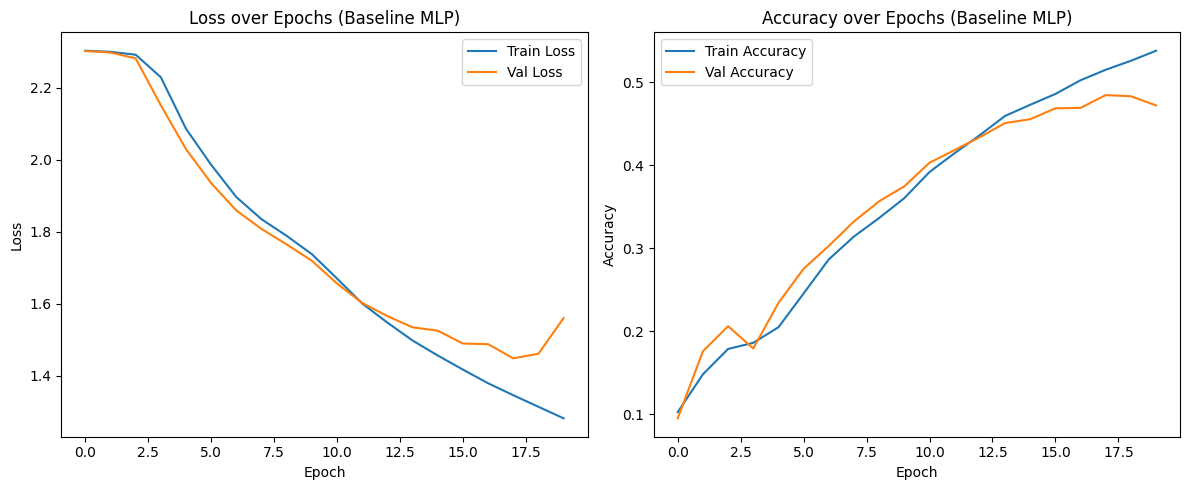

In [16]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs (Baseline MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Accuracy over Epochs (Baseline MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


>🔍 What Did We Observe?

- **Training Loss** steadily decreased across epochs — showing that the model is learning from the data.
- **Validation Loss** initially followed training loss but later **flattened and fluctuated**, a common sign of **overfitting or unstable generalization**.
- **Accuracy curves** tell a similar story:
  - **Training Accuracy** continued to improve smoothly.
  - **Validation Accuracy** rose at first but then **plateaued or dipped**, failing to match the training performance.

> >**⚠️ Challenges Observed in the Baseline Model**

| Issue                     | What We Saw                                   | Why It Matters                           |
|--------------------------|-----------------------------------------------|------------------------------------------|
| **Slow Convergence**     | Gradual improvement in loss and accuracy      | Training takes longer, inefficient learning |
| **Overfitting Signals**  | Train accuracy >> Val accuracy after some epochs | Model may not generalize well             |
| **Fluctuating Validation** | Val loss/accuracy bounce around mid-training | Model may be sensitive to noise or lack regularization |
| **Poor Gradient Flow**   | Especially in early layers (as seen in NB02)  | Some layers may not be learning at all   |

</br>

>✅ Why This Baseline Is Important

This baseline highlights **real pain points** in training deep MLPs:
- No **Batch Normalization** → unstable training dynamics.
- No **weight regularization** → overfitting kicks in early.
- Simple **SGD optimizer** → slower adaptation compared to modern optimizers.

It gives us a solid reference point for improvement.

➡️ **Up Next**: We’ll address these issues by integrating **Batch Normalization** into the architecture to improve stability, learning speed, and generalization.

---

### **4. Add Batch Normalization**

**🧠 Why Batch Normalization?**

As we saw in our baseline training:

- Deeper networks struggle with **unstable gradients** and **slow learning**.
- Even with good initialization, learning can be **fragile and noisy**.

**Batch Normalization (BatchNorm)** was proposed to address these challenges. It works by **normalizing the inputs to each layer** within a mini-batch during training.

>🔬 What Does BatchNorm Do?

Think of each hidden layer as receiving inputs that keep changing during training — this is called **internal covariate shift**. BatchNorm fixes this by:

1. **Normalizing activations**: It ensures each layer receives inputs with **mean ≈ 0** and **std ≈ 1**.
2. **Stabilizing gradients**: Makes backpropagation smoother across all layers.
3. **Allowing faster training**: Enables use of **higher learning rates**.
4. **Acts as a mild regularizer**: Helps reduce overfitting (often reduces need for Dropout!).

>📊 Where Is BatchNorm Applied?

For fully connected (MLP) networks:
> We apply `BatchNorm1d` **after each `Linear` layer** and **before the activation** (`ReLU`, `Tanh`, etc.).

Think of this pattern: ```plaintext Linear → BatchNorm → ReLU ```


**Define MLP with Batch Normalization**

In [46]:
class MLP_BatchNorm(nn.Module):
    def __init__(self, input_dim=3072, output_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, output_dim)  # output logits
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model and optimizer
model_bn = MLP_BatchNorm().to(device)

**Re-train with BatchNorm Model**

In [47]:
torch.manual_seed(42)  # For reproducibility
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=0.01)

# Tracking
train_losses_bn, val_losses_bn = [], []
train_accs_bn, val_accs_bn = [], []

epochs = 20

for epoch in range(epochs):
    model_bn.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses_bn.append(running_loss / total)
    train_accs_bn.append(correct / total)

    # Validation
    model_bn.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_bn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses_bn.append(val_loss / val_total)
    val_accs_bn.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Acc: {train_accs_bn[-1]:.4f}, Val Acc: {val_accs_bn[-1]:.4f}")

Epoch [1/20] - Train Acc: 0.3618, Val Acc: 0.4306
Epoch [2/20] - Train Acc: 0.4460, Val Acc: 0.4621
Epoch [3/20] - Train Acc: 0.4800, Val Acc: 0.4807
Epoch [4/20] - Train Acc: 0.5097, Val Acc: 0.4945
Epoch [5/20] - Train Acc: 0.5296, Val Acc: 0.5048
Epoch [6/20] - Train Acc: 0.5454, Val Acc: 0.5101
Epoch [7/20] - Train Acc: 0.5654, Val Acc: 0.5129
Epoch [8/20] - Train Acc: 0.5810, Val Acc: 0.5086
Epoch [9/20] - Train Acc: 0.5945, Val Acc: 0.5216
Epoch [10/20] - Train Acc: 0.6065, Val Acc: 0.5184
Epoch [11/20] - Train Acc: 0.6202, Val Acc: 0.5193
Epoch [12/20] - Train Acc: 0.6311, Val Acc: 0.5282
Epoch [13/20] - Train Acc: 0.6406, Val Acc: 0.5180
Epoch [14/20] - Train Acc: 0.6539, Val Acc: 0.5194
Epoch [15/20] - Train Acc: 0.6605, Val Acc: 0.5156
Epoch [16/20] - Train Acc: 0.6715, Val Acc: 0.5215
Epoch [17/20] - Train Acc: 0.6810, Val Acc: 0.5184
Epoch [18/20] - Train Acc: 0.6877, Val Acc: 0.5189
Epoch [19/20] - Train Acc: 0.6975, Val Acc: 0.5235
Epoch [20/20] - Train Acc: 0.7069, Val A

**Compare Training Curves (Before vs After BatchNorm)**

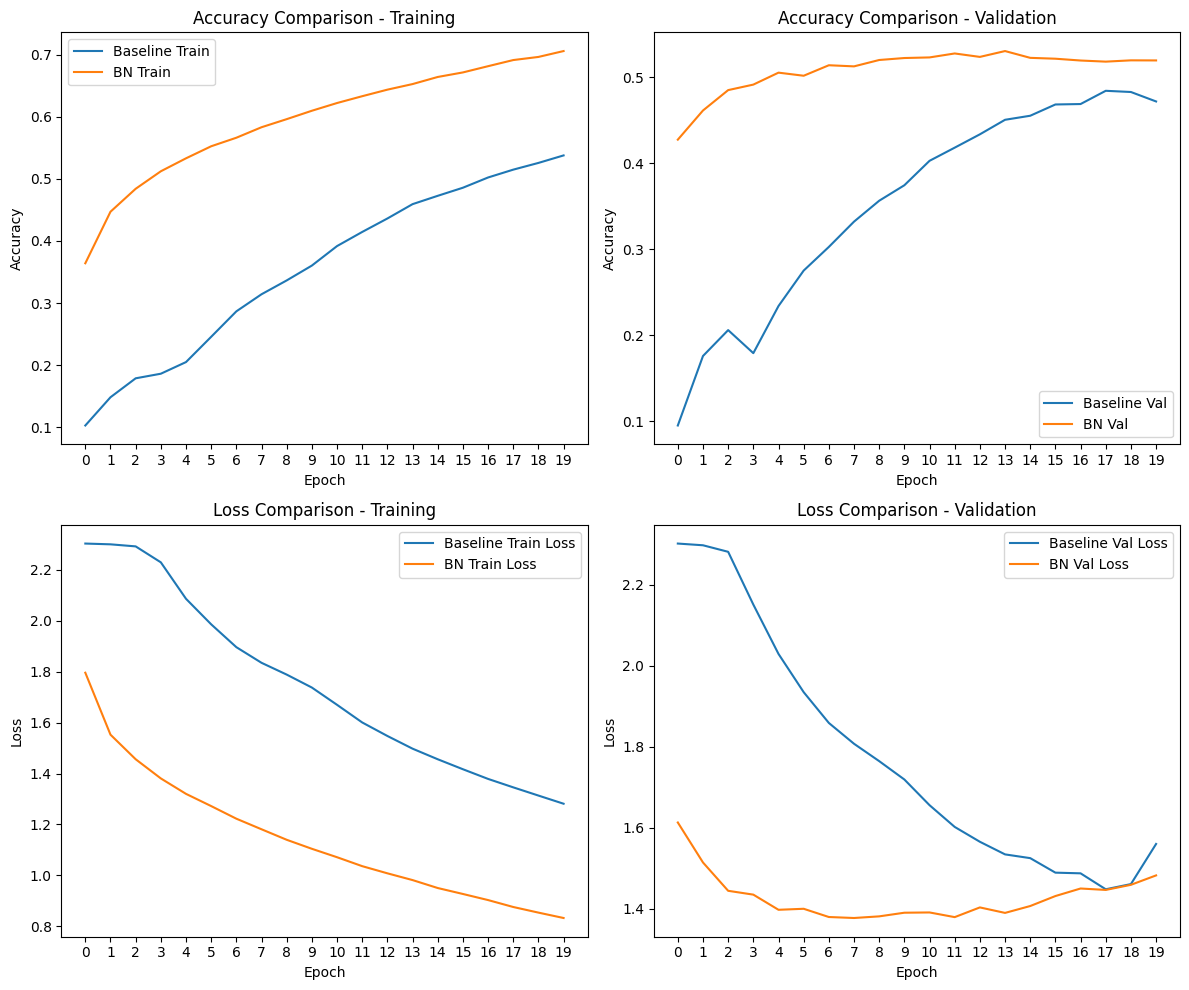

In [23]:
plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label="Baseline Train")
plt.plot(train_accs_bn, label="BN Train")
plt.title("Accuracy Comparison - Training")
plt.xticks(range(epochs))  # Ensures ticks are integers from 0 to num_epochs - 1
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(val_accuracies, label="Baseline Val")
plt.plot(val_accs_bn, label="BN Val")
plt.title("Accuracy Comparison - Validation")
plt.xticks(range(epochs))  # Ensures ticks are integers from 0 to num_epochs - 1
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(2, 2, 3)
plt.plot(train_losses, label="Baseline Train Loss")
plt.plot(train_losses_bn, label="BN Train Loss")
plt.title("Loss Comparison - Training")
plt.xticks(range(epochs))  # Ensures ticks are integers from 0 to num_epochs - 1
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Loss
plt.subplot(2, 2, 4)
plt.plot(val_losses, label="Baseline Val Loss")
plt.plot(val_losses_bn, label="BN Val Loss")
plt.title("Loss Comparison - Validation")
plt.xticks(range(epochs))  # Ensures ticks are integers from 0 to num_epochs - 1
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Let’s interpret the comparison plots above:

- ✅ **Faster convergence**: The model with BatchNorm reaches higher accuracy **much earlier** than the baseline, both on training and validation sets.

- ✅ **Smoother training**: Training and validation **loss curves are more stable**, showing reduced noise and more consistent learning.

- ✅ **Better generalization**: The BatchNorm model not only trains faster — it also **achieves higher validation accuracy**, especially in early epochs. That means it’s learning patterns that **generalize better to unseen data**.

>**💡 Why Does BatchNorm Help?**

Batch Normalization improves training dynamics in several ways:

| 🔍 Mechanism                        | 🧠 How It Helps                                                    |
|------------------------------------|---------------------------------------------------------------------|
| **Normalizes activations**         | Keeps inputs to each layer in a **similar range** — avoids instability |
| **Reduces internal covariate shift** | Makes each layer less sensitive to changes in the previous layers   |
| **Stabilizes gradient flow**       | Avoids vanishing/exploding gradients — helps deeper layers learn    |
| **Acts like regularization**       | Adds noise during training — reduces overfitting slightly           |

</br>

Even though we didn’t change the optimizer or learning rate, **just inserting BatchNorm** dramatically improved the MLP’s training behavior.

📌 **Note**: We did **not add Dropout or L2 yet**, and we’re still using **vanilla SGD** — so the gains we see are purely due to BatchNorm.

➡️ Up next: Let’s explore how **different optimizers** like **Adam** and **RMSProp** affect training speed and stability.

---

### **5. Optimizer Comparison**

In this section, we’ll explore how different **optimizers** impact training speed, stability, and final performance.

We’ll compare:
- **SGD**
- **Adam**
- **RMSProp**

All models use the **same architecture** (Deep MLP with BatchNorm) — the only thing we change is the optimizer.

>🧠 Why Optimizer Choice Matters

An **optimizer** is the engine that updates weights in a neural network. It decides *how fast* and *in what direction* each parameter should move based on the gradient.

Different optimizers use different strategies:
- Some move steadily but slowly (like SGD),
- Others adapt to the landscape and accelerate learning (like Adam and RMSProp).

Let’s break them down.

**What Are These Optimizers?**

| Optimizer | Idea | How It Works | Pros | Cons |
|----------|------|--------------|------|------|
| **SGD (Stochastic Gradient Descent)** | Uses gradient as-is | Updates weights by subtracting gradient scaled by learning rate | Simple, stable, well-understood | Can be slow to converge, sensitive to learning rate |
| **SGD + Momentum** | Adds inertia | Combines current gradient with a moving average of past gradients | Helps escape local minima, speeds up convergence | Needs tuning of momentum parameter |
| **Adam** | Adaptive + Momentum | Tracks mean and variance of gradients separately for each parameter | Fast convergence, works well out of the box | May overfit, less interpretable |
| **RMSProp** | Squashes learning rate | Maintains a moving average of squared gradients and scales updates | Good for noisy or non-stationary data | Needs learning rate tuning |

</br>

>🔬 Intuition Behind the Updates

- **SGD**: Like walking downhill with your eyes closed — just follow the current slope. This is good for **interpretable and stable** training, but can get stuck or move slowly.

- **SGD + Momentum**: Adds "memory" — keeps moving in the same direction if gradients stay consistent. It helps accelerate across flat regions or small bumps.

- **Adam**: Combines **momentum** (mean of gradients) + **scaling** (variance of gradients). It adapts the learning rate **for each parameter** individually. This is like a smart GPS that adjusts your speed based on terrain.

- **RMSProp**: Adjusts learning rates by **shrinking** them when gradients are large. Very useful in unstable or noisy optimization landscapes.

We’ll now train the same deep MLP using:

- SGD (with momentum)
- Adam (adaptive learning rate)
- RMSProp

We’ll compare all three using:
- Training and validation **loss**
- Training and validation **accuracy**
- How **stable and fast** the learning is across epochs

➡️ Let’s see how these optimizers differ in practice.

**Define Model & Training Function**

We'll define a reusable function to train any model with any optimizer.

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model_with_optimizer(optimizer_name="SGD", epochs=10, seed=42):
    # Set seed for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Initialize model
    model = MLP_BatchNorm().to(device)
    criterion = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "SGD_momentum":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    else:
        raise ValueError("Unsupported optimizer")

    # Tracking
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss_epoch, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss_epoch / total)
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        val_loss_epoch, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss_epoch += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss_epoch / val_total)
        val_accuracies.append(val_correct / val_total)

        # Print progress
        print(f"[{optimizer_name}] Epoch {epoch+1}/{epochs} - "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, model


**Run Training with All Optimizers**

In [49]:
# Train with all optimizers
eval_opt_results = {}
for opt in ["SGD", "SGD_momentum", "Adam", "RMSProp"]:
    print(f"\n🚀 Training with {opt}")
    eval_opt_results[opt] = train_model_with_optimizer(optimizer_name=opt, epochs=20)


🚀 Training with SGD


[SGD] Epoch 1/20 - Train Acc: 0.3621, Val Acc: 0.4319
[SGD] Epoch 2/20 - Train Acc: 0.4495, Val Acc: 0.4659
[SGD] Epoch 3/20 - Train Acc: 0.4844, Val Acc: 0.4846
[SGD] Epoch 4/20 - Train Acc: 0.5133, Val Acc: 0.4887
[SGD] Epoch 5/20 - Train Acc: 0.5329, Val Acc: 0.5011
[SGD] Epoch 6/20 - Train Acc: 0.5499, Val Acc: 0.5077
[SGD] Epoch 7/20 - Train Acc: 0.5639, Val Acc: 0.5143
[SGD] Epoch 8/20 - Train Acc: 0.5822, Val Acc: 0.5152
[SGD] Epoch 9/20 - Train Acc: 0.5927, Val Acc: 0.5131
[SGD] Epoch 10/20 - Train Acc: 0.6084, Val Acc: 0.5196
[SGD] Epoch 11/20 - Train Acc: 0.6196, Val Acc: 0.5167
[SGD] Epoch 12/20 - Train Acc: 0.6344, Val Acc: 0.5148
[SGD] Epoch 13/20 - Train Acc: 0.6423, Val Acc: 0.5204
[SGD] Epoch 14/20 - Train Acc: 0.6536, Val Acc: 0.5214
[SGD] Epoch 15/20 - Train Acc: 0.6623, Val Acc: 0.5227
[SGD] Epoch 16/20 - Train Acc: 0.6696, Val Acc: 0.5147
[SGD] Epoch 17/20 - Train Acc: 0.6804, Val Acc: 0.5171
[SGD] Epoch 18/20 - Train Acc: 0.6875, Val Acc: 0.5146
[SGD] Epoch 19/20 -

**Plot Accuracy and Loss Curves**

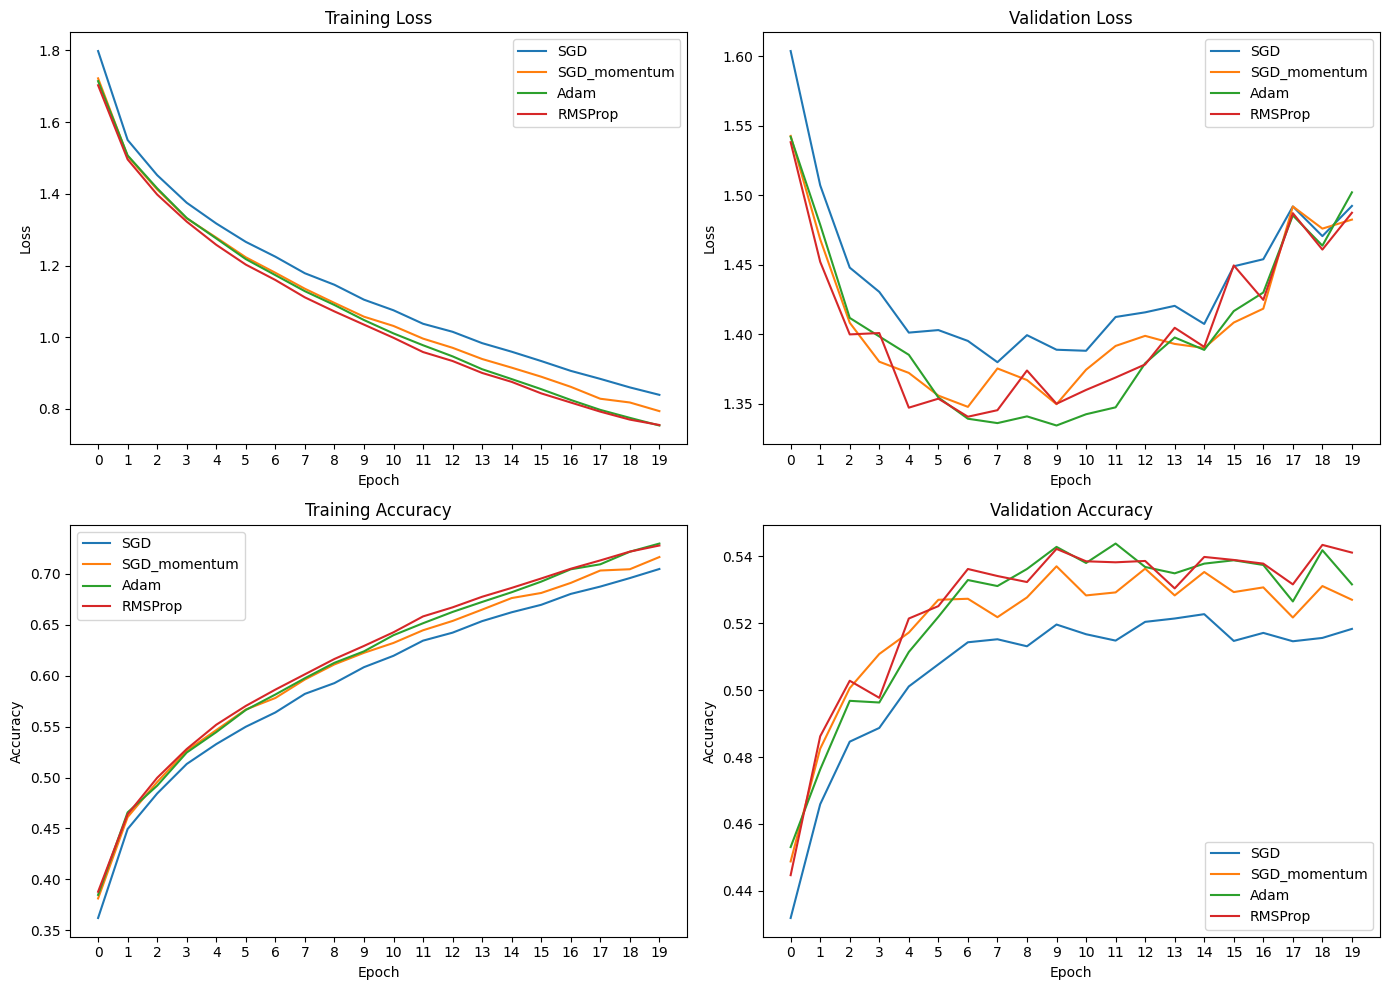

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# 1. Training Loss
plt.subplot(2, 2, 1)
for opt in eval_opt_results:
    plt.plot(eval_opt_results[opt][0], label=f"{opt}")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(len(eval_opt_results[opt][0])))  # Show integer ticks

# 2. Validation Loss
plt.subplot(2, 2, 2)
for opt in eval_opt_results:
    plt.plot(eval_opt_results[opt][1], label=f"{opt}")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(len(eval_opt_results[opt][1])))

# 3. Training Accuracy
plt.subplot(2, 2, 3)
for opt in eval_opt_results:
    plt.plot(eval_opt_results[opt][2], label=f"{opt}")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(len(eval_opt_results[opt][2])))

# 4. Validation Accuracy
plt.subplot(2, 2, 4)
for opt in eval_opt_results:
    plt.plot(eval_opt_results[opt][3], label=f"{opt}")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(len(eval_opt_results[opt][3])))

plt.tight_layout()
plt.show()


Based on the plots comparing `SGD`, `SGD + momentum`, `Adam`, and `RMSProp`, here’s what we observe:

**1. Training Loss (Top-Left Plot)**

- **Adam** and **RMSProp** show the **fastest and smoothest decrease** in training loss.
- **SGD + Momentum** improves over plain SGD, but still trails behind adaptive methods.
- **SGD** converges slowly — it struggles to efficiently update weights in deep networks.

**2. Validation Loss (Top-Right Plot)**

- All optimizers improve early on, but:
  - **Adam** and **RMSProp** reach **lower validation loss** faster.
  - **SGD** has **higher and more unstable** validation loss over time.
- After ~10 epochs, most curves start to **plateau or rise**, hinting at early **overfitting**.

**3. Training Accuracy (Bottom-Left Plot)**

- **Adam** and **RMSProp** again outperform others in training accuracy.
- **SGD + Momentum** makes a clear improvement over plain SGD.
- **SGD** stays behind — its updates are slower and less effective.

**4. Validation Accuracy (Bottom-Right Plot)**

- **Adam** and **RMSProp** achieve the **best final accuracy**, peaking around **0.54**.
- **SGD + Momentum** follows closely and performs respectably.
- **SGD** levels off early — showing weaker generalization.

>**📌 Summary Table**

| Optimizer         | 🏃 Train Speed | 🎯 Final Val Acc | 📉 Stability      | 🔧 Best For                        |
|------------------|----------------|------------------|-------------------|------------------------------------|
| **SGD**          | ❌ Slow         | ⚠️ Lower          | ❌ Fluctuates      | Simple models / intro-level demos  |
| **SGD + Momentum** | ⚠️ Moderate     | ⚠️ Fair           | ✅ More stable     | Safer alternative to plain SGD     |
| **Adam**         | ✅ Fast         | ✅ High           | ✅ Smooth          | Most practical default             |
| **RMSProp**      | ✅ Fast         | ✅ High           | ✅ Stable          | Similar to Adam, slightly noisier  |

</br>

>🎯 What's Next?

In the next section, we’ll tackle another challenge: **overfitting**.

➡️ Let’s explore how techniques like **Dropout** and **L2 regularization** can further improve generalization!

---

### **6. Add Dropout + L2 Regularization**

To further improve generalization and reduce overfitting, we’ll now combine **two widely used regularization techniques**:

> 🔒 **Dropout** + **L2 Weight Decay**

**🧠 Why Regularization?**

Overfitting occurs when a model learns to **memorize the training data** — instead of discovering patterns that generalize to unseen data.

Regularization techniques aim to:
- **Prevent over-reliance** on specific neurons or weights
- **Encourage smoother, simpler** decision boundaries
- **Improve robustness** to noise or data shifts

>**🔎 Two Common Regularization Strategies**

>🔹 Dropout

*What it does:* Randomly “drops” neurons during training.

Each training step uses a slightly different sub-network by **turning off (zeroing out)** some neurons with probability `p`. This forces the network to:
- Not rely too heavily on specific neurons
- Learn **redundant representations**
- Act like **an ensemble of smaller networks**

Mathematically, if `rᵢ ∼ Bernoulli(p)` is a binary mask:
$$
\tilde{x}_i = x_i \cdot r_i
$$

During inference (testing), we **scale activations down** instead of applying dropout — to match the expected behavior.

🧠 Think of it as: “Shuffling which neurons are allowed to speak each time — so no one neuron becomes a dictator.”

>🔹 L2 Weight Decay (a.k.a. Ridge Regularization)

*What it does:* Penalizes **large weights** in the loss function.

A secondary term is added to the loss:
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{CrossEntropy}} + \lambda \sum w^2
$$

Why it helps:
- Encourages **smaller weight magnitudes**
- Reduces model complexity (smoother decision boundaries)
- Helps prevent overfitting, especially with many features or layers

🧠 Think of it as: “Tugging the weights back toward zero — gently discouraging extreme values.”

**🔧 Implementation Strategy**

We’ll add:
- `Dropout(p=0.5)` **after each activation**
- `L2 penalty` using the `weight_decay` argument in the optimizer

This builds on our BatchNorm-enhanced MLP.

**Define Model with Dropout**

In [34]:
import torch.nn as nn

class MLP_With_Dropout(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=128, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    

**Train with Adam + Weight Decay**

In [35]:
def train_dropout_l2_model(epochs=10, weight_decay=1e-4):
    torch.manual_seed(42)  # For reproducibility

    model = MLP_With_Dropout().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss.append(val_running_loss / val_total)
        val_acc.append(val_correct / val_total)

        print(f"[Dropout+L2] Epoch {epoch+1}/{epochs} - "
              f"Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc, model

# Train the model with dropout and L2 regularization
results_dropout_l2 = train_dropout_l2_model(epochs=20)


[Dropout+L2] Epoch 1/20 - Train Acc: 0.3406, Val Acc: 0.4317
[Dropout+L2] Epoch 2/20 - Train Acc: 0.4051, Val Acc: 0.4572
[Dropout+L2] Epoch 3/20 - Train Acc: 0.4346, Val Acc: 0.4786
[Dropout+L2] Epoch 4/20 - Train Acc: 0.4537, Val Acc: 0.4964
[Dropout+L2] Epoch 5/20 - Train Acc: 0.4636, Val Acc: 0.4993
[Dropout+L2] Epoch 6/20 - Train Acc: 0.4733, Val Acc: 0.5158
[Dropout+L2] Epoch 7/20 - Train Acc: 0.4882, Val Acc: 0.5123
[Dropout+L2] Epoch 8/20 - Train Acc: 0.4933, Val Acc: 0.5099
[Dropout+L2] Epoch 9/20 - Train Acc: 0.5036, Val Acc: 0.5109
[Dropout+L2] Epoch 10/20 - Train Acc: 0.5053, Val Acc: 0.5196
[Dropout+L2] Epoch 11/20 - Train Acc: 0.5161, Val Acc: 0.5269
[Dropout+L2] Epoch 12/20 - Train Acc: 0.5167, Val Acc: 0.5181
[Dropout+L2] Epoch 13/20 - Train Acc: 0.5235, Val Acc: 0.5267
[Dropout+L2] Epoch 14/20 - Train Acc: 0.5243, Val Acc: 0.5292
[Dropout+L2] Epoch 15/20 - Train Acc: 0.5304, Val Acc: 0.5377
[Dropout+L2] Epoch 16/20 - Train Acc: 0.5354, Val Acc: 0.5361
[Dropout+L2] Epoc

**Note**
In our model, we’re applying **two complementary regularization techniques**:

>Dropout (in the Model)
- Dropout is applied **during the forward pass**.
- It randomly "turns off" neurons (e.g., 20%) to prevent **co-adaptation**.
- This forces the network to learn **robust and redundant features**.

>L2 Regularization (in the Optimizer)
- L2 is applied **during the optimizer step** via the `weight_decay` parameter.
- It penalizes large weights using:
  $$
  \text{Loss}_{\text{total}} = \text{Loss}_{\text{CE}} + \lambda \sum w^2
  $$
- This encourages **simpler models** with smaller weights and better generalization.

✅ **Using Both Together** is common and effective:
- Dropout helps at the **neuron level**.
- L2 helps at the **weight level**.

So when we write:
```python
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
```
we're applying L2 regularization on top of the Dropout layers already inside the model — and that’s a good thing!

**Plot Performance**

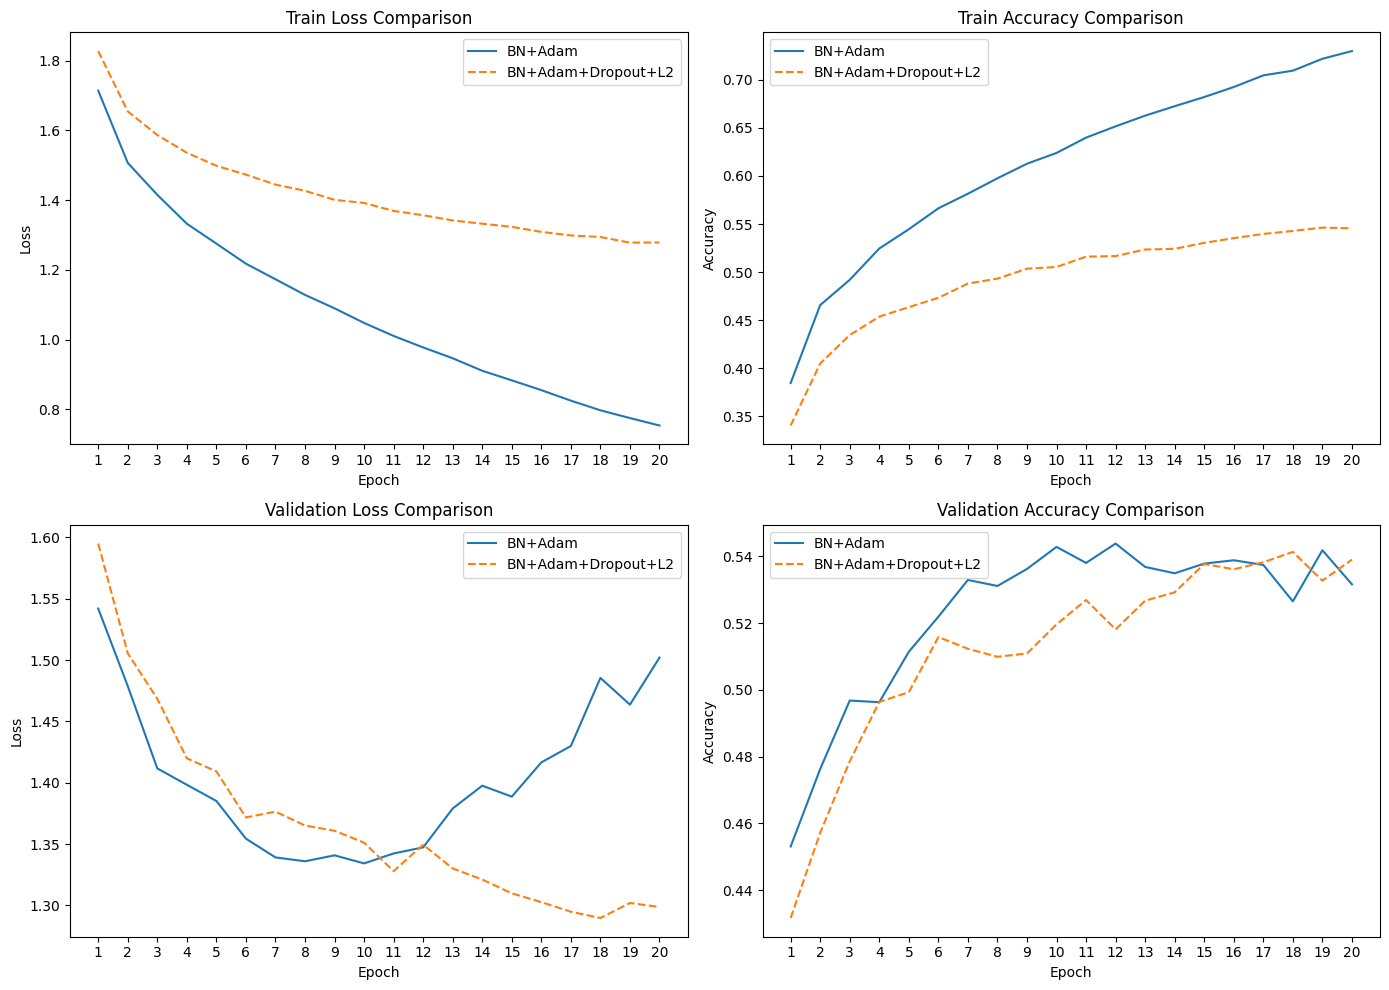

In [ ]:
plt.figure(figsize=(14, 10))

# 1. Train Loss
plt.subplot(2, 2, 1)
plt.plot(eval_opt_results["Adam"][0], label="BN+Adam")
plt.plot(results_dropout_l2[0], label="BN+Adam+Dropout+L2", linestyle='--')
plt.title("Train Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(0, len(eval_opt_results["Adam"][0])), labels=range(1, len(eval_opt_results["Adam"][0]) + 1))  # integer ticks
plt.legend()

# 2. Train Accuracy
plt.subplot(2, 2, 2)
plt.plot(eval_opt_results["Adam"][2], label="BN+Adam")
plt.plot(results_dropout_l2[2], label="BN+Adam+Dropout+L2", linestyle='--')
plt.title("Train Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0, len(eval_opt_results["Adam"][2])), labels=range(1, len(eval_opt_results["Adam"][2]) + 1))
plt.legend()

# 3. Validation Loss
plt.subplot(2, 2, 3)
plt.plot(eval_opt_results["Adam"][1], label="BN+Adam")
plt.plot(results_dropout_l2[1], label="BN+Adam+Dropout+L2", linestyle='--')
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(0, len(eval_opt_results["Adam"][1])), labels=range(1, len(eval_opt_results["Adam"][1]) + 1))
plt.legend()

# 4. Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(eval_opt_results["Adam"][3], label="BN+Adam")
plt.plot(results_dropout_l2[3], label="BN+Adam+Dropout+L2", linestyle='--')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0, len(eval_opt_results["Adam"][3])), labels=range(1, len(eval_opt_results["Adam"][3]) + 1))
plt.legend()

plt.tight_layout()
plt.show()


**Regularization Impact: BN+Adam vs BN+Adam+Dropout+L2**

>📉 Training Loss & Accuracy

- The **BN + Adam** model (without regularization) shows **lower training loss** and **higher training accuracy** throughout.
- This is expected — **regularized models are intentionally penalized** during training to encourage better generalization.

>📊 Validation Loss & Accuracy

- Despite underperforming on training metrics, the **BN + Adam + Dropout + L2** model maintains **competitive validation accuracy** and **lower validation loss** in later epochs.
- This suggests that regularization is helping the model **avoid overfitting**, especially toward the end of training.

>🧠 **What This Tells Us**

| Metric         | BN + Adam ✅                     | BN + Adam + Dropout + L2 ✅ |
|----------------|----------------------------------|-----------------------------|
| Train Loss     | Lower (fits training well)       | Higher (due to Dropout & L2) |
| Train Accuracy | Higher (possibly overfitting)    | Lower (regularized learning) |
| Val Loss       | Rises in later epochs            | Remains lower & stable      |
| Val Accuracy   | Peaks early, then fluctuates     | Slightly more stable        |

➡️ **Regularization may slow learning**, but helps prevent the model from "memorizing" training data — especially when we care about **performance on unseen data**.


> **⚠️ When Regularization Might Not Help**

There are cases where Dropout or L2 regularization might **hurt performance**:

- When the model is already **underfitting** (not learning well even on training data)
- When the **dataset is small** or very **clean and simple**
- When **training is short** and the model hasn’t yet started to overfit

In such cases, regularization might **suppress learning unnecessarily**. So we should always **evaluate both training and validation performance** before deciding whether to regularize.

📌 **Takeaway**: Adding Dropout and L2 is not meant to boost training accuracy — it's meant to **sacrifice some training performance** to gain **better generalization**, which is the goal in most real-world applications.

---

### **8. Final Model Evaluation**

Now that we’ve explored various training techniques, let’s compare the final models based on:

>**Evaluation Metrics**

| Metric         | What It Measures                                                                 |
|----------------|-----------------------------------------------------------------------------------|
| ✅ **Test Accuracy** | Overall proportion of correct predictions.                                 |
| 🧠 **Macro F1 Score** | Harmonic mean of precision and recall, **averaged across all classes**.     |
| ⏱️ **Inference Time** | Time taken to predict the entire test set. Useful for comparing efficiency. |

</br>

>🧮 What We’ll Do

1. Use the test set (never seen during training).
2. Evaluate these models:
   - **Baseline** (no BatchNorm or optimization tricks)
   - **BatchNorm only**
   - **BN + Adam Optimizer**
   - **BN + Adam + Dropout + L2 Regularization**
3. For each:
   - Compute **Accuracy**, **Macro F1**, and **per-class metrics**
   - Store results in a DataFrame
   - Visualize the results using bar plots

This will help us clearly see the **trade-offs between complexity and performance**.


In [39]:
_, _, _, _, model_bestopt = train_model_with_optimizer("Adam", epochs=20)
_, _, _, _, model_reg = train_dropout_l2_model(epochs=20)


[Adam] Epoch 1/20 - Train Acc: 0.3847, Val Acc: 0.4531
[Adam] Epoch 2/20 - Train Acc: 0.4658, Val Acc: 0.4763
[Adam] Epoch 3/20 - Train Acc: 0.4920, Val Acc: 0.4968
[Adam] Epoch 4/20 - Train Acc: 0.5246, Val Acc: 0.4963
[Adam] Epoch 5/20 - Train Acc: 0.5446, Val Acc: 0.5114
[Adam] Epoch 6/20 - Train Acc: 0.5664, Val Acc: 0.5219
[Adam] Epoch 7/20 - Train Acc: 0.5815, Val Acc: 0.5329
[Adam] Epoch 8/20 - Train Acc: 0.5976, Val Acc: 0.5311
[Adam] Epoch 9/20 - Train Acc: 0.6127, Val Acc: 0.5362
[Adam] Epoch 10/20 - Train Acc: 0.6239, Val Acc: 0.5428
[Adam] Epoch 11/20 - Train Acc: 0.6398, Val Acc: 0.5380
[Adam] Epoch 12/20 - Train Acc: 0.6515, Val Acc: 0.5438
[Adam] Epoch 13/20 - Train Acc: 0.6626, Val Acc: 0.5368
[Adam] Epoch 14/20 - Train Acc: 0.6725, Val Acc: 0.5349
[Adam] Epoch 15/20 - Train Acc: 0.6820, Val Acc: 0.5378
[Adam] Epoch 16/20 - Train Acc: 0.6924, Val Acc: 0.5388
[Adam] Epoch 17/20 - Train Acc: 0.7045, Val Acc: 0.5374
[Adam] Epoch 18/20 - Train Acc: 0.7094, Val Acc: 0.5265
[

In [55]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation function
def evaluate_model(model, dataloader, name="Model"):
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    duration = time.time() - start_time
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f"🔍 {name} | Test Accuracy: {acc:.4f} | Macro F1: {f1:.4f} | Inference Time: {duration:.2f}s")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return acc, f1, duration


In [57]:
# Use previously trained models
model_baseline = eval_opt_results["SGD"][4]                # Baseline: SGD without momentum
model_bn = eval_opt_results["SGD_momentum"][4]             # With BatchNorm + SGD+momentum
model_bestopt = eval_opt_results["Adam"][4]                # With BatchNorm + Adam
model_reg = results_dropout_l2[4]                 # With BN + Adam + Dropout + L2

# Evaluate each model
eval_results = []
models_to_evaluate = [
    ("Baseline (SGD)", model_baseline),
    ("BN (SGD+Momentum)", model_bn),
    ("BN + Adam", model_bestopt),
    ("BN + Adam + Dropout + L2", model_reg)
]

for name, model in models_to_evaluate:
    acc, f1, duration = evaluate_model(model, test_loader, name)
    eval_results.append((name, acc, f1, duration))

🔍 Baseline (SGD) | Test Accuracy: 0.5156 | Macro F1: 0.5147 | Inference Time: 0.66s
              precision    recall  f1-score   support

    airplane       0.60      0.58      0.59      1000
  automobile       0.63      0.58      0.60      1000
        bird       0.42      0.37      0.39      1000
         cat       0.37      0.33      0.35      1000
        deer       0.43      0.50      0.46      1000
         dog       0.42      0.42      0.42      1000
        frog       0.51      0.58      0.54      1000
       horse       0.58      0.55      0.56      1000
        ship       0.65      0.64      0.65      1000
       truck       0.55      0.60      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000

🔍 BN (SGD+Momentum) | Test Accuracy: 0.5185 | Macro F1: 0.5164 | Inference Time: 0.53s
              precision    recall  f1-score   support

    airplane   

In [58]:
# Convert to DataFrame
df_results = pd.DataFrame(eval_results, columns=["Model", "Accuracy", "Macro F1", "Time (s)"])
print(df_results)

                      Model  Accuracy  Macro F1  Time (s)
0            Baseline (SGD)    0.5156  0.514731  0.661202
1         BN (SGD+Momentum)    0.5185  0.516414  0.531294
2                 BN + Adam    0.5272  0.524047  0.571076
3  BN + Adam + Dropout + L2    0.5359  0.529847  0.487007


**Bar Plot Visualization**

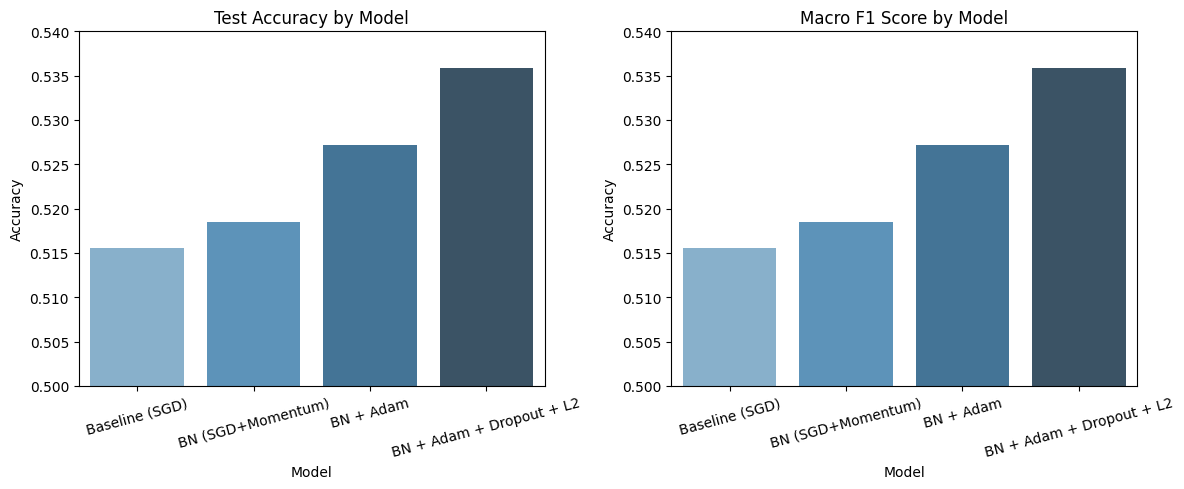

In [59]:
# Bar plot comparison
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
sns.barplot(data=df_results, x="Model", y="Accuracy", palette="Blues_d", hue="Model", legend=False)
plt.ylim(0.50, 0.54)
plt.title("Test Accuracy by Model")
plt.xticks(rotation=15)

# F1 Score
plt.subplot(1, 2, 2)
sns.barplot(data=df_results, x="Model", y="Accuracy", palette="Blues_d", hue="Model", legend=False)
plt.ylim(0.50, 0.54)
plt.title("Macro F1 Score by Model")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


After training and evaluating multiple deep MLP variants, here’s what we observed on the test set:

| Model                        | Test Accuracy | Macro F1 Score |
|-----------------------------|---------------|----------------|
| **Baseline (SGD)**          | 51.56%        | 0.5147         |
| **BN (SGD + Momentum)**     | 51.85%        | 0.5164         |
| **BN + Adam**               | 52.72%        | 0.5240         |
| **BN + Adam + Dropout + L2**| **53.59%**    | **0.5298**     |

</br>

- **Each enhancement improved performance** over the baseline:
  - **BatchNorm** offered modest gains in both accuracy and stability.
  - **Adam** sped up convergence and improved generalization.
  - **Dropout + L2** further boosted test performance by reducing overfitting.

- **Regularization + Adam + BatchNorm** was the best combination in this experiment.

In [ ]:
# Save model_bestopt
torch.save(model_bestopt.state_dict(), "model_bestopt_NB03.pth")

**🧠 What We Learned**

- Deep networks benefit **greatly** from thoughtful **design choices**.
- Training dynamics are sensitive to:
  - Initialization (NB02)
  - Normalization (BN)
  - Optimizers (SGD, Adam, etc.)
  - Regularization (Dropout, L2)

Each piece helps the network **learn faster**, **stabilize gradients**, and **generalize better**.

> 🚀 What's Next?

In the next notebook, we’ll move beyond MLPs and introduce **Convolutional Neural Networks (CNNs)** — the workhorse for image-based deep learning.

---